### Time Series Analysis : ARIMA Model

Auto-Regressive Integrated Moving Average (ARIMA) model is the most general class of models for forecasting a time series which can be made to be “stationary” by differencing, perhaps in conjunction with nonlinear transformations such as logging or deflating. 

A random variable that is a time series is **stationary** if its statistical properties are all constant over time. A stationary series has no trend, its variations around its mean have a constant amplitude, and it wiggles in a consistent fashion, i.e., its short-term random time patterns always look the same in a statistical sense. The latter condition means that its autocorrelations remain constant over time, or equivalently, that its power spectrum remains constant over time. 

A random variable of this form can be viewed as a combination of signal and noise, and the signal could be a pattern of fast or slow mean reversion, or sinusoidal oscillation, or rapid alternation in sign, and it could also have a seasonal component.  An ARIMA model can be viewed as a “filter” that tries to separate the signal from the noise, and the signal is then extrapolated into the future to obtain forecasts.

ARIMA model is usually denoted an $ARIMA(p,d,q)$ model, where:

* $p$ is the order of autoregressive terms $AR$
* $d$ is the number of nonseasonal differences needed for stationarity
* $q$ is the order of lagged forecast errors in the prediction equation $MA$

The general forecasting equation of ARIMA is:

$$\hat{y}_t = \mu + \varphi_{1}y_{t-1} + ...+\varphi_{p}y_{t-p} - \theta_{1}\varepsilon_{t-1}-...-\theta_{q}\varepsilon_{t-q}$$


Note that $y$ denote the d-th difference of $Y$ (the orignal time series), which means:

*  $\text{If } d=0 \Longrightarrow y_t  =  Y_t$
*  $\text{If } d=1 \Longrightarrow y_t  =  Y_t - Y_{t-1}$
* $\text{If } d=2 \Longrightarrow y_t = (Y_t - Y_{t-1}) - (Y_{t-1} - Y_{t-2})  =  Y_t - 2Y_{t-1} + Y_{t-2}$


To identify the appropriate ARIMA model for time series $Y$, you begin by determining the order of differencing $d$ needing to **stationarize** the series and remove the gross features of seasonality, perhaps in conjunction with a variance-stabilizing transformation such as logging or deflating. However, the stationarized series may still have autocorrelated errors, suggesting that some number of $AR$ terms ($p ≥ 1$) and/or some number $MA$ terms ($q ≥ 1$) are also needed in the forecasting equation.

The process of determining the values of $p$, $d$, and $q$ that are best for a given time series will be discussed in later sections of the notes, but a preview of some of the types of nonseasonal ARIMA models that are commonly encountered is given below.



**There are two major factors that make a time series non-stationary. They are:**
* **Trend**: non-constant mean
* **Seasonality**: Variation at specific time-frames

The basic idea is to model the trend and seasonality in this series, so we can remove it and make the series stationary. Then we can go ahead and apply statistical forecasting to the stationary series. And finally we can convert the forecasted values into original by applying the trend and seasonality constrains back to those that we previously separated.

####  1. Stabilize variance using log transform

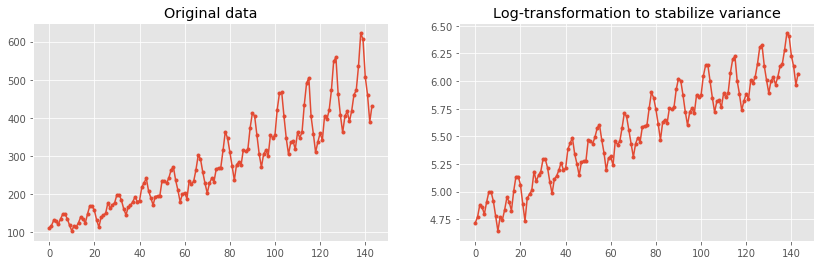

In [78]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
passenger_data = pd.read_csv('AirPassengers.csv')
passenger_data.Month = pd.to_datetime(passenger_data.Month, 
                                      infer_datetime_format=True)

y = passenger_data['#Passengers']
y_log = np.log(passenger_data['#Passengers'])
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
axes[0].plot(y, '.-')
axes[0].set_title('Original data')
axes[1].plot(y_log, '.-')
axes[1].set_title('Log-transformation to stabilize variance')
plt.show()

####  2. Detrend the data by subtracting moving average

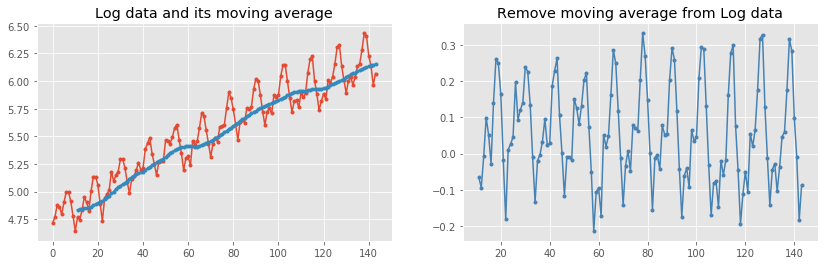

ADF Statistic: -3.162908
p-value: 0.022235
Time Series is non-stationary
Critical Values:
	1%: -3.487
	5%: -2.886
	10%: -2.580


In [119]:
# subtract the rolling mean from the original series
moving_avg = y_log.rolling(12).mean()
y_log_remove_ma = y_log - moving_avg
y_log_remove_ma.dropna(inplace=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
axes[0].plot(y_log, '.-', label='Log data')
axes[0].plot(moving_avg, '.-', label='Moving average')
axes[0].set_title('Log data and its moving average')
axes[1].plot(y_log_remove_ma, '.-', color='steelblue')
axes[1].set_title('Remove moving average from Log data')
plt.show()

# test for stationary
from statsmodels.tsa.stattools import adfuller
alpha = 0.02 # You can choose arbitrary level of significance
adf_test = adfuller(y_log_remove_ma)
test_stat, p_value, cirtical_values= adf_test[0], adf_test[1], adf_test[4]

print('ADF Statistic: %f' % test_stat)
print('p-value: %f' % p_value)
print('Time Series is non-stationary') if p_value > alpha \
                       else print('Time Series is stationary')
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

#### 3. Identifying the order of differencing
Previously we saw just trend part of the time series, now we will see both trend and seasonality. Most Time series have trends along with seasonality. There are two common methods to remove trend and seasonality, they are:
* **Differencing**: by taking difference using time lag
* **Decomposition**: model both trend and seasonality, then remove them

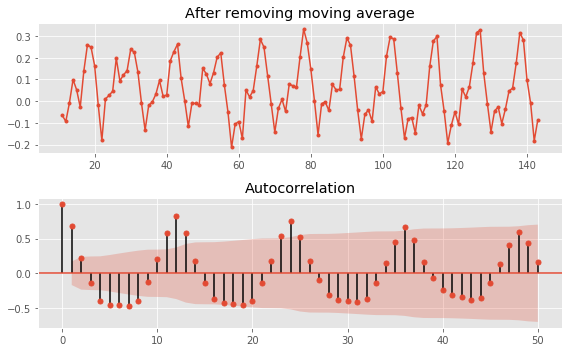

In [120]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 5))
axes[0].plot(y_log_remove_ma, '.-')
axes[0].set_title('After removing moving average')
tsaplots.plot_acf(y_log_remove_ma.dropna(), lags=50, ax=axes[1])
plt.tight_layout()
plt.show()

The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.
If
1. The series still exhibits a long-term trend, or  
2. Otherwise lacks a tendency to return to its mean value, or 
3. If its autocorrelations are positive out to a high number of lags (e.g., 10 or more)

Then it needs a higher order of differencing. 

**Rule 1: If the series has positive autocorrelations out to a high number of lags, then it probably needs a higher order of differencing.**

Differencing tends to introduce negative correlation: if the series initially shows strong positive autocorrelation, then a **nonseasonal** difference will reduce the autocorrelation and perhaps even drive the lag 1 autocorrelation to a negative value. If you apply a second nonseasonal difference (which is occasionally necessary), the lag 1 autocorrelation will be driven even further in the negative direction.

**If the lag 1 autocorrelation is zero or even negative, then the series does not need further differencing.**
One of the most common errors in ARIMA modeling is to "overdifference" the series and end up adding extra AR or MA terms to undo the damage. If the lag 1 autocorrelation is more negative than -0.5, this may mean the series has been overdifferenced. 

**Rule 2: If the lag 1 autocorrelation is zero or negative, or the autocorrelations are all small and patternless, then the series does not need a higher order of  differencing. If the lag 1 autocorrelation is -0.5 or more negative, the series may be overdifferenced.**

Another symptom of possible overdifferencing is an increase in the standard deviation, rather than a reduction, when the order of differencing is increased. This becomes our third rule:

**Rule 3: The optimal order of differencing is often the order of differencing at which the standard deviation is lowest.**

**Rule 4: A model with no orders of differencing assumes that the original series is stationary (mean-reverting). A model with one order of differencing assumes that the original series has a constant average trend. A model with two orders of total differencing assumes that the original series has a time-varying trend.**

Another consideration in determining the order of differencing is the role played by the CONSTANT term in the model--if one is included. We generally do not assume that there are trends-in-trends, so the constant is usually removed from models with two orders of differencing. In a model with one order of differencing, the constant may or may not be included, depending on whether we do or do not want to allow for an average trend. Hence we have:

**Rule 5: A model with no orders of differencing normally includes a constant term (which allows for a non-zero mean value). A model with two orders of total differencing normally does not include a constant term. In a model with one order of total differencing, a constant term should be included if the series has a non-zero average trend.**

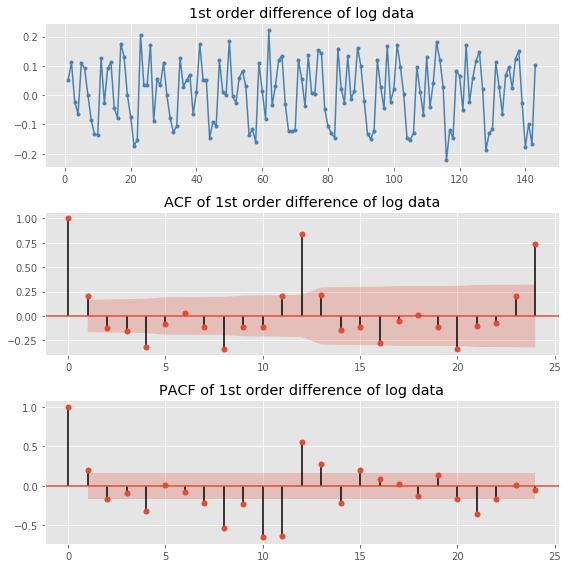

ADF Statistic: -2.717131
p-value: 0.071121
Time Series is non-stationary
Critical Values:
	1%: -3.483
	5%: -2.884
	10%: -2.579


In [126]:
y_log_diff = y_log.diff().dropna()
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 8))
title = '1st order difference of log data'
axes[0].plot(y_log_diff, '.-', color='steelblue')
axes[0].set_title(title)
n_lags = 24
tsaplots.plot_acf(y_log_diff.dropna(), lags=n_lags, ax=axes[1], title='ACF of ' + title)
tsaplots.plot_pacf(y_log_diff.dropna(), lags=n_lags, ax=axes[2], title='PACF of ' + title)
plt.tight_layout()
plt.show()

# test for stationary
from statsmodels.tsa.stattools import adfuller
alpha = 0.05 # You can choose arbitrary level of significance
adf_test = adfuller(y_log_diff.dropna())
test_stat, p_value, cirtical_values= adf_test[0], adf_test[1], adf_test[4]

print('ADF Statistic: %f' % test_stat)
print('p-value: %f' % p_value)
print('Time Series is non-stationary') if p_value > alpha else print('Time Series is stationary')
print('Critical Values:')
for key, value in adf_test[4].items():
    print('\t%s: %.3f' % (key, value))

### 4. Identify the number of AR or MA terms in an ARIMA model
After a time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series. Of course, with software like R and Python, you could just try some different combinations of terms and see what works best. But there is a more systematic way to do this - by looking at the autocorrelation function (ACF) and partial autocorrelation (PACF) plots of the differenced series.

**AR signature**

Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. So, we initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.If the PACF displays a sharp cutoff while the ACF decays more slowly (i.e., has significant spikes at higher lags), we say that the stationarized series displays an AR signature, meaning that the autocorrelation pattern can be explained more easily by adding AR terms than by adding MA terms. You will probably find that an AR signature is commonly associated with positive autocorrelation at lag 1.

**Rule 6: If the PACF of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is positive, then consider adding an AR term to the model. $\color{red}{\text{The lag at which the PACF cuts off is the indicated number of AR terms.}}$**

**MA signature**

In principle, any autocorrelation pattern can be removed from a stationarized series by adding enough AR terms. However, this is not always the simplest way to explain a given pattern of autocorrelation: sometimes it is more efficient to add MA terms instead. The autocorrelation function (ACF) plays the same role for MA terms that the PACF plays for AR terms. If the autocorrelation is significant at lag k but not at any higher lags--i.e., if the ACF "cuts off" at lag k--this indicates that exactly $k$ MA terms should be used in the forecasting equation. In the latter case, we say that the stationarized series displays an MA signature meaning that the autocorrelation pattern can be explained more easily by adding MA terms than by adding AR terms. An MA signature is commonly associated with negative autocorrelation at lag 1. 

**Rule 7: If the ACF of the differenced series displays a sharp cutoff and/or the lag-1 autocorrelation is negative, then consider adding an MA term to the model. $\color{red}{\text{The lag at which the ACF cuts off is the indicated number of MA terms.}}$**

#### 5. Fit the ARIMA Model

In [108]:
from statsmodels.tsa.arima_model import ARIMA

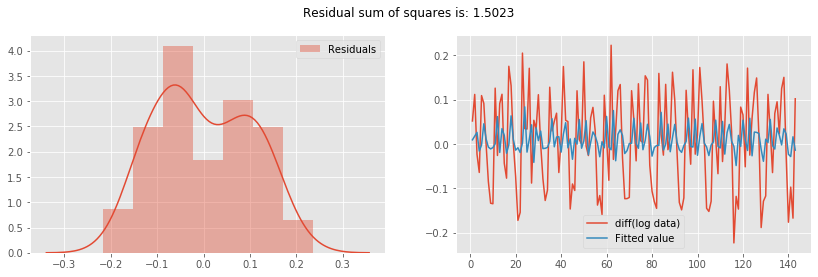

                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 0)   Log Likelihood                 122.802
Method:                       css-mle   S.D. of innovations              0.102
Date:                Thu, 12 Mar 2020   AIC                           -237.605
Time:                        15:36:55   BIC                           -225.753
Sample:                             1   HQIC                          -232.789
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0096      0.009      1.048      0.296      -0.008       0.028
ar.L1.D.#Passengers     0.2359      0.083      2.855      0.005       0.074       0.398
ar.L2.D.#Passeng

In [180]:
# AR model
model = ARIMA(y_log, order=(2,1,0))
results_AR = model.fit()
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.distplot(results_AR.resid, label='Residuals')
plt.legend()
plt.subplot(1,2,2)
plt.plot(y_log_diff, label='diff(log data)')
plt.plot(results_AR.fittedvalues, label='Fitted value')
plt.legend()
plt.suptitle('Residual sum of squares is: %.4f'%np.sum(results_AR.resid**2))
plt.show()
print(results_AR.summary())

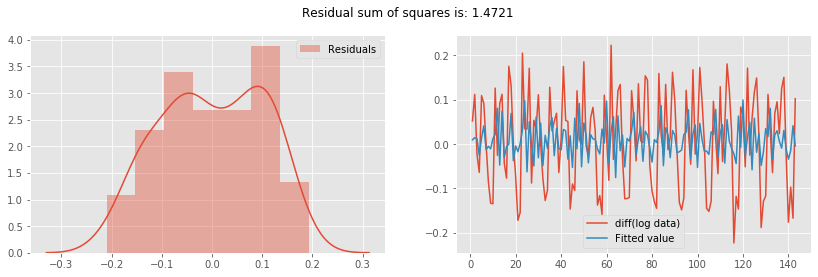

                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 124.189
Method:                       css-mle   S.D. of innovations              0.101
Date:                Thu, 12 Mar 2020   AIC                           -240.379
Time:                        15:36:32   BIC                           -228.528
Sample:                             1   HQIC                          -235.563
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0096      0.007      1.314      0.191      -0.005       0.024
ma.L1.D.#Passengers     0.2019      0.120      1.688      0.094      -0.033       0.436
ma.L2.D.#Passeng

In [179]:
# MA model
model = ARIMA(y_log, order=(0,1,2))
results_MA = model.fit()
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.distplot(results_MA.resid, label='Residuals')
plt.legend()
plt.subplot(1,2,2)
plt.plot(y_log_diff, label='diff(log data)')
plt.plot(results_MA.fittedvalues, label='Fitted value')
plt.legend()
plt.suptitle('Residual sum of squares is: %.4f'%np.sum(results_MA.resid**2))
plt.show()
print(results_MA.summary())

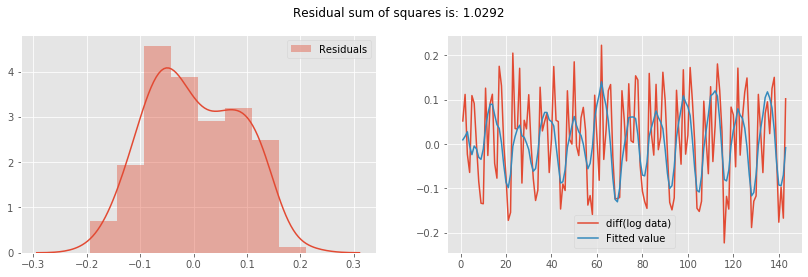

                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  143
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 149.640
Method:                       css-mle   S.D. of innovations              0.084
Date:                Thu, 12 Mar 2020   AIC                           -287.281
Time:                        15:36:09   BIC                           -269.504
Sample:                             1   HQIC                          -280.057
                                                                              
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0096      0.003      3.697      0.000       0.005       0.015
ar.L1.D.#Passengers     1.6293      0.039     41.868      0.000       1.553       1.706
ar.L2.D.#Passeng

In [178]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(y_log, order=(2,1,2))
results_ARIMA = model.fit()
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.distplot(results_ARIMA.resid, label='Residuals')
plt.legend()
plt.subplot(1,2,2)
plt.plot(y_log_diff, label='diff(log data)')
plt.plot(results_ARIMA.fittedvalues, label='Fitted value')
plt.legend()
plt.suptitle('Residual sum of squares is: %.4f'%np.sum(results_ARIMA.resid**2))
plt.show()
print(results_ARIMA.summary())

In [177]:
np.sum((results_ARIMA.fittedvalues - y_log_diff)**2)

1.0291519977316788

**ARIMA has the best RSS values.**

Convert everything back to the original scale:
* First get the predicted values and store it as series. You will notice the first month is missing because we took a lag of 1(shift).
* Now convert differencing to log scale: find the cumulative sum and add it to a new series with a base value (here the first-month value of the log series).

In [219]:
pred_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues)
pred_ARIMA = pred_ARIMA_diff.cumsum() + y_log[0]

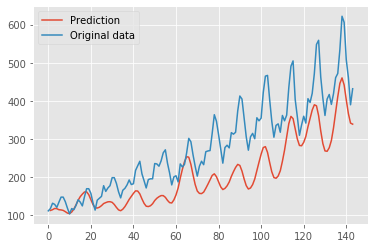

In [224]:
plt.plot(np.exp(pred_ARIMA), label='Prediction')
plt.plot(y, label='Original data')
plt.legend()
plt.show()